In [23]:
#import litebird_sim as lbs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import mueller_convolver
import mueller_convolver_revice
import ducc0
#import random

In [24]:
nside = 128
lmax = 3*nside-1
fwhm = np.deg2rad(5)

In [25]:
alm = np.load(f"alm=CMB=r0=nside{nside}.npy")
alm[0,:] = 0 # see the only pol
alm_for_mc = np.zeros((4,alm[0,:].size), dtype = alm.dtype)
alm_for_mc[0:3] = alm
map_in = hp.alm2map(hp.smoothalm(alm,fwhm = fwhm), nside =nside)

In [26]:
def blm_gauss_new(fwhm, lmax, pol=False):
    fwhm = float(fwhm)
    lmax = int(lmax)
    pol = bool(pol)
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = np.sqrt((2*l+1) / (4*np.pi)) \
            * np.exp(-0.5*sigmasq*l*(l+1))

    if pol:
        for l in range(2, lmax+1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = np.sqrt((2*l+1) / (32*np.pi)) \
                * np.exp(-0.5 * sigmasq * (l*(l+1)-4))
        blm[2] = 1j * blm[1]

    return blm

In [27]:
blm = blm_gauss_new(fwhm = fwhm, lmax = lmax, pol = True)
#blm = hp.blm_gauss(fwhm = fwhm, lmax = lmax, pol = True)
blm[1:3,:] *= -np.sqrt(2)
blm_for_mc = np.zeros((4,blm[0,:].size), dtype = blm.dtype)
blm_for_mc[0:3] = blm
kmax = 2

In [28]:
nptg = 100
ptg = np.empty((nptg,3))
ptg[:,0]=np.random.uniform(0,np.pi,size=(nptg,))    # theta
ptg[:,1]=np.random.uniform(0,2*np.pi,size=(nptg,))  # phi
ptg[:,2]=np.random.uniform(0,2*np.pi,size=(nptg,))  # psi
hwp_angles = np.random.uniform(0,2*np.pi,size=(nptg,))  # alpha

In [29]:
# ideal HWP
mueller = np.zeros((4,4))
mueller[0,0] = 1
mueller[1,1] = 1
mueller[2,2] = -1

In [30]:
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=alm_for_mc,
    blm=blm_for_mc,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-5,
    nthreads=1
)

0
3
4


In [31]:
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)
signal_muellerconvolver_invangle = fullconv.signal(ptg=ptg, alpha=-hwp_angles)

In [32]:
# functions to calclate scan case

def rotation(psi):
    return np.array([[1, 0, 0],
              [0,np.cos(2*psi),np.sin(2*psi)],
              [0,-np.sin(2*psi),np.cos(2*psi)]])
def scan_out(nptg,ptg, map_in, mueller):
    output = np.zeros(nptg)
    a = np.array([1,0,0])
    det  = np.array([[1,1,0],
                     [1,1,0],
                     [0,0,0]
    ])
    for index, ptg_ in enumerate(ptg):
        I_temp = hp.get_interp_val(map_in[0], ptg_[0], ptg_[1])
        Q_temp = hp.get_interp_val(map_in[1], ptg_[0], ptg_[1])
        U_temp = hp.get_interp_val(map_in[2], ptg_[0], ptg_[1])
        S_in = np.array([[I_temp],[Q_temp],[U_temp]])
        output[index] = a @ det @ rotation(-hwp_angles[index]) @ mueller[0:3,0:3] @ rotation(hwp_angles[index]) @ rotation(ptg_[2]) @ S_in
    return output

In [33]:
scan = scan_out(nptg,ptg, map_in, mueller)

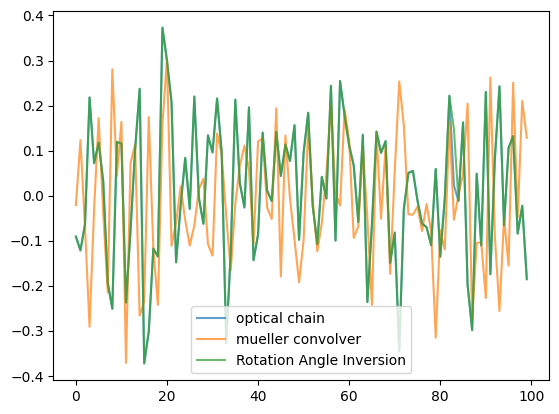

In [34]:
plt.plot(scan,alpha = 0.7, label = "optical chain")
plt.plot(signal_muellerconvolver, alpha = 0.7, label = "mueller convolver")
plt.plot(signal_muellerconvolver_invangle, alpha = 0.7, label = "Rotation Angle Inversion")
plt.legend()

# Check non-diagonal elements

In [13]:
mueller = np.zeros((4,4))
#mueller[0,1] = 1
#mueller[0,2] = 1
#mueller[1,2] = 1
#mueller[2,1] = 1
mueller[2,1] = 1
#mueller[2,1] = 1

In [14]:
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=alm_for_mc,
    blm=blm_for_mc,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-10,
    nthreads=1
)

0
3
4


In [15]:
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)
signal_muellerconvolver_invangle = fullconv.signal(ptg=ptg, alpha=-hwp_angles)
scan = scan_out(nptg,ptg, map_in, mueller)

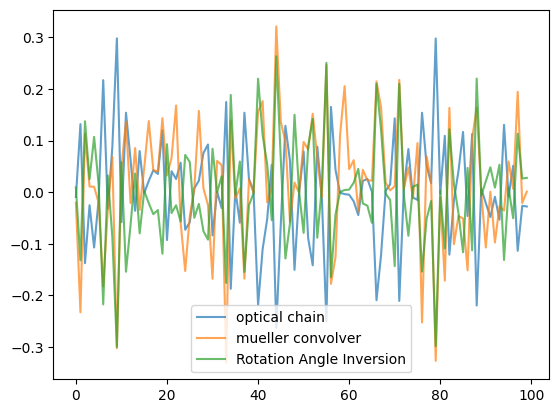

In [16]:
plt.plot(scan,alpha = 0.7, label = "optical chain")
plt.plot(signal_muellerconvolver, alpha = 0.7, label = "mueller convolver")
plt.plot(signal_muellerconvolver_invangle, alpha = 0.7, label = "Rotation Angle Inversion")
plt.legend()

It will not match even if the rotation angle is reversed, and may only match if it is not reversed.

## Modified version

$$
{_{0}b_{\ell m}^{HWP}} = 
     C_{II}^{\ast} {_{0}b_{\ell m}} +  C_{PI}^{\ast} e^{-2i\alpha}{_{2}b_{\ell, m-2}}/\sqrt2 +  C_{P^{\ast}I}^{\ast} e^{2i\alpha}{_{-2}b_{\ell, m+2}} /\sqrt2  \\
    {_{2}b_{\ell m}^{HWP}} = 
     \sqrt2  C_{IP}^{\ast}e^{2i\alpha} {_{0}b_{\ell, m+2}} +  C_{PP}^{\ast} {_{2}b_{\ell m}} +  C_{P^{\ast}P}^{\ast} e^{4i\alpha}{_{-2}b_{\ell ,m+4}} \\
    {_{-2}b_{\ell m}^{HWP}} =  
     \sqrt2  C_{IP^{\ast}}^{\ast} e^{-2i\alpha}{_{0}b_{\ell, m-2}} +  C_{PP^{\ast}}^{\ast}e^{-4i\alpha} {_{2}b_{\ell, m-4}} +  C_{P^{\ast}P^{\ast}}^{\ast} {_{-2}b_{\ell, m}}
$$

In [35]:
import mueller_convolver_modified

In [18]:
mueller = np.random.random((4, 4))*2-1
#mueller = np.zeros((4,4))
#mueller[2,1] = -1

In [19]:
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=alm_for_mc,
    blm=blm_for_mc,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-10,
    nthreads=1
)

fullconv_modified = mueller_convolver_revice.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=alm_for_mc,
    blm=blm_for_mc,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-10,
    nthreads=1
)

0
1
2
3
4
0
1
2
3
4


In [20]:
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)
signal_muellerconvolver_invangle = fullconv.signal(ptg=ptg, alpha=-hwp_angles)
signal_muellerconvolver_modified = fullconv_modified.signal(ptg=ptg, alpha=hwp_angles)

In [21]:
scan = scan_out(nptg, ptg, map_in, mueller)

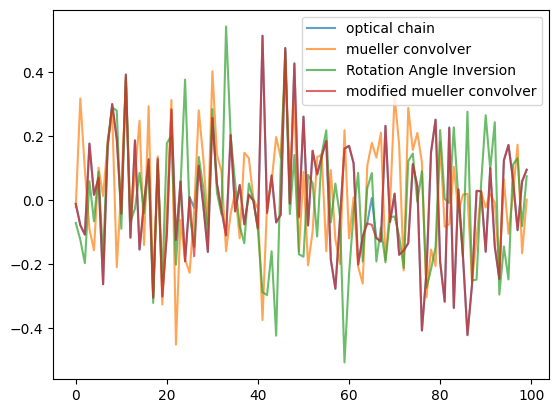

In [22]:
plt.plot(scan,alpha = 0.7, label = "optical chain")
plt.plot(signal_muellerconvolver, alpha = 0.7, label = "mueller convolver")
plt.plot(signal_muellerconvolver_invangle, alpha = 0.7, label = "Rotation Angle Inversion")
plt.plot(signal_muellerconvolver_modified, alpha = 0.7, label = "modified mueller convolver")
plt.legend()